**Common Test I. Multi-Class Classification**

---



---
For this problem, 3 object identification method have been applied, where I have used ResNet18 pretrained model. As the images are greyscale, to make it compatible with data, one more Convolution layer have been added after ResNet pretrained layer  .



In [ ]:
!gdown 1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ

In [2]:
!unzip -q "/content/dataset.zip"

In [3]:
!pip install torchvision

In [1]:
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os
notebook_path = os.getcwd()
print(notebook_path)

/content


In [13]:
!ls /content/dataset/val

no  sphere  vort


In [6]:
cp -r /content/dataset/val/no /content/test_no

In [7]:
cp -r /content/dataset/train/sphere /content/train_sphere

In [8]:
cp -r /content/dataset/val/sphere /content/test_sphere

In [9]:
cp -r /content/dataset/train/vort /content/train_vort

In [10]:
cp -r /content/dataset/train/no /content/train_no

In [11]:




cp -r /content/dataset/val/vort /content/test_vort

In [3]:
#Building the datset from data and labelling them with 0,1,2 for identification
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/content"
        no_train="train_no"
        sphere_train='train_sphere'
        vort_train="train_vort"
        no_test="test_no"
        sphere_test='test_sphere'
        vort_test="test_vort"

        no_train_file_path=os.path.join(directory,no_train)
        no_test_file_path=os.path.join(directory,no_test)
        sphere_train_file_path=os.path.join(directory,sphere_train)
        sphere_test_file_path=os.path.join(directory,sphere_test)

        vort_train_file_path=os.path.join(directory,vort_train)
        vort_test_file_path=os.path.join(directory,vort_test)

        no_train_files=[os.path.join(no_train_file_path,file) for file in os.listdir(no_train_file_path) if file.endswith(".npy")]
        sphere_train_files=[os.path.join(sphere_train_file_path,file) for file in os.listdir(sphere_train_file_path) if file.endswith(".npy")]
        vort_train_files=[os.path.join(vort_train_file_path,file) for file in os.listdir(vort_train_file_path) if file.endswith(".npy")]

        no_test_files=[os.path.join(no_test_file_path,file) for file in os.listdir(no_test_file_path) if file.endswith(".npy")]

        sphere_test_files=[os.path.join(sphere_test_file_path,file) for file in os.listdir(sphere_test_file_path) if file.endswith(".npy")]

        vort_test_files=[os.path.join(vort_test_file_path,file) for file in os.listdir(vort_test_file_path) if file.endswith(".npy")]


        number_of_train_samples=len(no_train_files)+len(sphere_train_files)+len(vort_train_files)
        number_of_test_samples=len(no_test_files)+len(sphere_test_files)+len(vort_test_files)
        number_of_samples=number_of_train_samples+number_of_test_samples
        self.all_files=[None]*number_of_samples
        self.all_files[:len(no_train_files)]=no_train_files
        self.all_files[len(no_train_files):len(no_train_files)+len(sphere_train_files)]=sphere_train_files
        self.all_files[len(no_train_files)+len(sphere_train_files):(number_of_train_samples)]=vort_train_files
        self.all_files[number_of_train_samples:number_of_train_samples+len(no_test_files)]=no_test_files
        self.all_files[number_of_train_samples+len(no_test_files):number_of_train_samples+len(no_test_files)+len(sphere_test_files)]=sphere_test_files
        self.all_files[number_of_train_samples+len(no_test_files)+len(sphere_test_files):]=vort_test_files


        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor

        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)









        self.Y[:len(no_train_files)]=0
        self.Y[len(no_train_files):len(no_train_files)+len(sphere_train_files)]=1
        self.Y[len(no_train_files)+len(sphere_train_files):(number_of_train_samples)]=2
        self.Y[number_of_train_samples:number_of_train_samples+len(no_test_files)]=0
        self.Y[number_of_train_samples+len(no_test_files):number_of_train_samples+len(no_test_files)+len(sphere_test_files)]=1
        self.Y[number_of_train_samples+len(no_test_files)+len(sphere_test_files):]=2


        if train:
            self.all_files=self.all_files[0:number_of_train_samples]
            self.Y=self.Y[0:number_of_train_samples]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[number_of_train_samples:]
            self.Y=self.Y[number_of_train_samples:]
            self.len=len(self.all_files)

    # Get the length
    def __len__(self):
        return self.len
    # Getter
    def __getitem__(self, idx):

        image=np.load(self.all_files[idx]).astype('float32')
        #image = Image.fromarray(image)


        #image = np.repeat(image,3,axis=0)

        y=self.Y[idx]

        # If there is any transform method, apply it onto the image
        if self.transform is not None:
            image = self.transform(image)

        return image, y

In [22]:
!ls "/content"

dataset      __MACOSX	  test_no      test_vort  train_sphere
dataset.zip  sample_data  test_sphere  train_no   train_vort


In [4]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


In [7]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [8]:
#Using pretrained ResNet18 model
model=models.resnet18(pretrained=True)

In [9]:
for param in model.parameters():
    param.requires_grad=False

In [10]:
# Adding Convolutional layer to make data compatible with ResNet18
model.conv1=nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3,bias=False)
model.fc=nn.Linear(512,3)

In [11]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
import os
#!ls "/content/test_lenses"
file1 = len(os.listdir("/content/train_no"))
file2=len(os.listdir("/content/train_vort"))
file3=len(os.listdir("/content/train_sphere"))
print(file1,file2,file3)

10000 10000 10000


In [13]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=100,shuffle=True)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=100,shuffle=False)

In [18]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad])

In [19]:
criterion= nn.CrossEntropyLoss()

In [20]:
#Training the data and checking for accuracy
n_epochs=5
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:

        model.train()
        #clear gradient
        optimizer.zero_grad()
        #make a prediction
        z=model(x.float())
        # calculate loss
        loss=criterion(z,y.long())
        # calculate gradients of parameters
        loss.backward()
        # update parameters
        optimizer.step()
        loss_list.append(loss.data)
    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval
        model.eval()
        #make a prediction
        z=model(x_test.float())
        #find max
        _,yhat=torch.max(z.data,1)

        #Calculate misclassified  samples in mini-batch
        correct +=(yhat==y_test).sum().item()

    accuracy=correct/N_test
    print(epoch,accuracy)

0 0.33813333333333334
1 0.36546666666666666
2 0.38
3 0.38306666666666667
4 0.4049333333333333


In [21]:
accuracy

0.4049333333333333

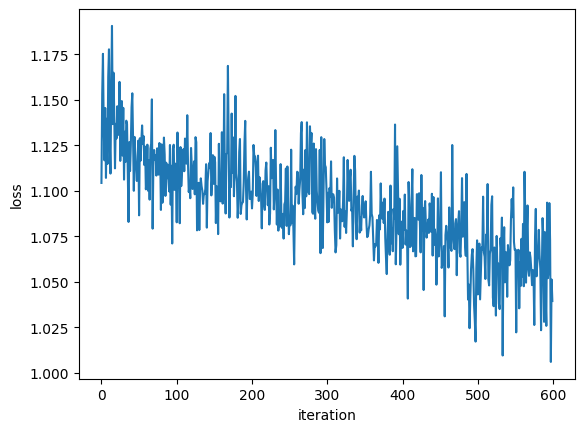

In [22]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [30]:
#Calculating ROC AUC values for plotting
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
def calculate_roc_auc(model, dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images.float())
            probs = torch.softmax(logits, dim=1)
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())

    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    return all_probs,all_labels

test_probs,test_labels=calculate_roc_auc(model, validation_loader, torch.device("cpu"))
binarized_labels = label_binarize(test_labels, classes=np.arange(3))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

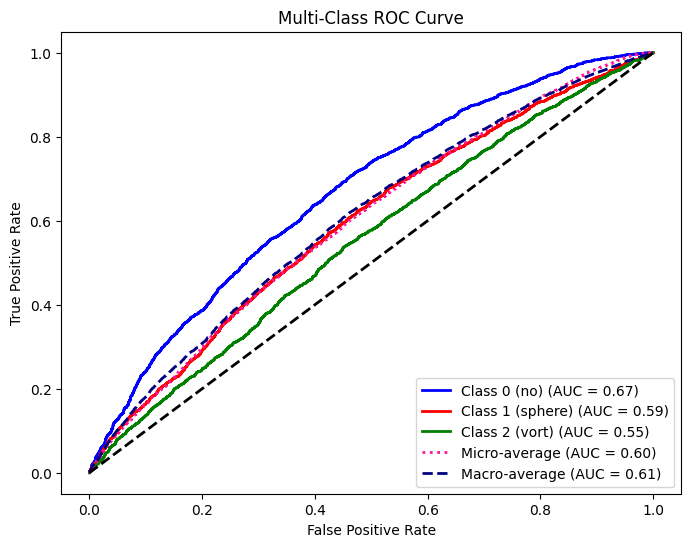

In [33]:
# ROC curves for different classes
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green'] # Adjust for your classes
classes = ['no', 'sphere', 'vort']
n_classes=3
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} ({classes[i]}) (AUC = {roc_auc[i]:.2f})')

# Plot micro/macro averages (optional)
# Micro-average (treat all classes as one)
fpr_micro, tpr_micro, _ = roc_curve(binarized_labels.ravel(), test_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', lw=2,
         label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

# Macro-average (average of per-class AUC)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)
plt.plot(all_fpr, mean_tpr, color='navy', linestyle='--', lw=2,
         label=f'Macro-average (AUC = {roc_auc_macro:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()